# Выпускной проект "Телеком"
## Описание задачи:
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
## Описание услуг:
Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*). 

Также доступны такие услуги:
1. Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
2. Выделенная линия технической поддержки (*TechSupport*);
3. Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
4. Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

## Описание данных:
1. contract.csv — информация о договоре

|признак|описание|
|---|---|
|customerID|клиентID|
|BeginDate|дата подключения|
|EndDate|дата отключения|
|Type|тип_подключения|
|PaperlessBilling|электронный_счет|
|PaymentMethod|способ_оплаты|
|MonthlyCharges|ежемесячный_платеж|
|TotalCharges|суммарный_платеж|

2. internet.csv — информация об интернет-услугах

|признак|описание|
|---|---|
|customerID|клиентID|
|InternetService|интернет_сервис|
|OnlineSecurity|онлайн_безопасность|
|OnlineBackup|резервное_копирование|
|DeviceProtection|защита_устройства|
|TechSupport|тех_поддержка|
|StreamingTV|СтримингТВ|
|StreamingMovies|СтримингФильмы|


3. personal.csv — персональные данные клиента

|признак|описание|
|---|---|
|customerID|клиентID|
|gender|пол|
|SeniorCitizen|пенсионер|
|Partner|партнер|
|Dependents|зависимые|

4. phone.csv — информация об услугах телефонии

|признак|описание|
|---|---|
|customerID|клиентID|
|MultipleLines|несколько_линий|

## Цель: 
создать модель оттока клиентов(клиент является отточным, если он ушел хотя бы на 1 день)

## Этапы исследования:

0. Импорт библиотек
1. Вспомогательные функции
2. Загрузка данных
3. Первичный анализ(добавил графики, хотя данных мало, и изначально я просто отобрал признаки на валидации, потому что это не отнимало много времени)           
    3.1. распределение клиентов с течением времени                     
    3.2. определение целевого признака                    
    3.3. распределение целевого признака (выбор схемы валидации)                    
    3.4. анализ пропущенных значений                 
    3.5. анализ числовых признаков                
    3.6. анализ категориальных признаков                 
    3.7. проверка гипотез             
    
4. Моделироавние          
    4.1. разделение данных на тренировочную, отложенную, тестовую части          
    4.2. определение метрик качества        
    4.3. определение схемы валидации      
    4.4. создание пайплайнов         
    4.5. отбор признаков           
    4.6. оптимизация гиперпараметров моделей           
    4.7. анализ предсказаний              
5. Формулировка выводов

### 0. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
import os, re, sys, gc, pickle, time
from collections import defaultdict

from sklearn.model_selection import GridSearchCV, cross_val_score,\
                                    KFold, train_test_split, cross_validate, ParameterGrid,\
                                    cross_validate, cross_val_predict, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import confusion_matrix
# пайплайн
from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, OneHotEncoder

# дамми-регрессор
from sklearn.dummy import DummyClassifier
from itertools import combinations
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.feature_selection import SelectFromModel
import shutil

### 1. Вспомогательные функции

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def convert_types(df):
    '''конвертирует типы (по возможности)'''
    df_c = df.copy()
    for col in df.columns:
        ser = df[col]
        try:
            ser2 = ser.astype('datetime64')
            df_c[col] = ser2
        except:
            try:
                ser2 =ser.astype(np.float32)
                df_c[col] =ser2
            except:
                pass
        
    return df_c[df_c.dtypes.sort_values().index]
    
class SklearnHelperColumnSelector(BaseEstimator, TransformerMixin):
    '''выбирает колонки, отпавляемые в пайплайн'''
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.columns]

class SklearnHelperLabelEncoder(TransformerMixin, BaseEstimator):
    ''' Факторизация категорий '''
    def __init__(self):
        pass
    def fit(self, X, y=None):
        X_c = X.astype(str)
        self.d1 = {}
        for col in X_c.columns:
            uniques = X_c[col].dropna().unique() 
            self.d1[col] =  dict(zip(uniques, range(len(uniques))))              
        return self
    def transform(self, X): 
        X_c = X.astype(str)
        for key, value in self.d1.items():
            X_c[key] = X_c[key].map(value)
        return X_c

class SklearnHelperTargetEncoder(BaseEstimator, TransformerMixin):
    ''' Кодирование категорий с помощью целевой переменной '''
    def __init__(self, n_iter, n_folds, min_samples_leaf, seed):
        self.n_iter = n_iter
        self.n_folds = n_folds
        self.min_samples_leaf = min_samples_leaf
        self.seed = seed
    def fit(self, X, y=None):
        self.y_mean = y.mean()
        _df_tr = pd.concat([X, y], 1)
        target_col = _df_tr.columns[-1]
        to_encode = _df_tr.columns[:-1]
        
        L_tr = []        
        self.L_d_encs = []
        for i in tqdm_notebook(range(self.n_iter)): 
            enc_tr = pd.DataFrame(index = _df_tr.index, columns = to_encode).fillna(0.0)
            for col in to_encode:
                for tr_idx, val_idx in KFold(self.n_folds, shuffle = True,random_state = self.seed+i)\
                                       .split(_df_tr):                    
                    grp = _df_tr.iloc[tr_idx].groupby(col)[target_col].agg({'mean', 'count'}) 
                    d_enc = grp[grp['count']>=self.min_samples_leaf]['mean'].to_dict()
                    self.L_d_encs.append((col, d_enc))
                    to_enc_tr =_df_tr.iloc[val_idx]                    
                    enc_tr.loc[to_enc_tr.index, col] = to_enc_tr[col].map(d_enc)                  
            L_tr.append(enc_tr)    
            
        self.enc_tr =  pd.concat(L_tr, 1)
        self._df_tr = _df_tr
        return self    
    def transform(self, X):
        if np.all(X.values == self._df_tr.values):
            return self.enc_tr.fillna(self.y_mean) 
        else:
            df_enc = pd.DataFrame(index = X.index, columns=X.columns).fillna(0.0)
            for feat, d in tqdm_notebook(self.L_d_encs):
                df_enc.loc[:, feat] += X[feat].map(d) / self.n_iter
            return df_enc.fillna(self.y_mean)
        
def train_hold_test_split(features, target, tr_size, ho_size, shuffle, random_state, stratify, use_test):
    if use_test:
        # делим данные на тренировочную, отложенную, тестовую части
        features_trho, features_te, target_trho, target_te = train_test_split(\
                                                                       features, target,\
                                                                       train_size = tr_size,\
                                                                       shuffle = shuffle, random_state = random_state,\
                                                                       stratify = target if stratify else None)
        features_tr, features_ho, target_tr, target_ho = train_test_split(\
                                                                       features_trho, target_trho,\
                                                                       train_size = 1-ho_size,\
                                                                       shuffle = shuffle, random_state = random_state,\
                                                                       stratify = target_trho if stratify else None)
        return (features_tr, features_ho, features_te, target_tr, target_ho, target_te)
    else:
        # делим данные на тренировочную, отложенную, тестовую части
        features_tr, features_ho, target_tr, target_ho = train_test_split(\
                                                             features, target,\
                                                             train_size = tr_size,\
                                                             shuffle = shuffle, random_state = random_state,\
                                                             stratify = target if stratify else None)
        print('train size = {}, hold size ={}'\
              .format(features_tr.shape[0], features_ho.shape[0]))
        return (features_tr, features_ho, target_tr, target_ho)
    
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [], -np.inf
        for i in tqdm_notebook(order):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]         
    
class SklearnHelperFeatureSelector(BaseEstimator, TransformerMixin):
    ''' Отбор признаков '''
    def __init__(self, model, cv, scoring, show_progress):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.show_progress = show_progress
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        _X = X.copy()
        cv_scores = []
        for i in tqdm_notebook(range(_X.shape[1])):
            try:
                _X_curr = _X[:, i].toarray().reshape(-1,1)
            except:
                _X_curr = _X[:, i].reshape(-1,1)                
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()            
            cv_scores.append(mean_cv_score)
            
        order = np.argsort(cv_scores)[::-1]
        to_drop_before, best_features, best_cv_score = [], [order[0]], -np.inf
        for i in tqdm_notebook(order[1:]):
            curr_features = best_features+[i]
            _X_curr = _X[:, curr_features]
            mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
            if mean_cv_score>best_cv_score:
                best_cv_score = mean_cv_score
                best_features = curr_features
                if self.show_progress:
                    print('new best score = {:.10f}'.format(best_cv_score))
            else:
                to_drop_before.append(i)
        while True:
            to_drop_after = []
            for i in tqdm_notebook(to_drop_before):
                curr_features = best_features+[i]
                _X_curr = _X[:, curr_features]
                mean_cv_score = cross_val_score(self.model, _X_curr, y, cv =self.cv, scoring = self.scoring, n_jobs=-1).mean()
                if mean_cv_score>best_cv_score:
                    best_cv_score = mean_cv_score
                    best_features = curr_features
                    if self.show_progress:
                        print('new best score = {:.10f}'.format(best_cv_score))
                else:
                    to_drop_after.append(i)
            if to_drop_before == to_drop_after:
                break
            else:
                to_drop_before = to_drop_after  
        self.best_features_ = best_features
        self.best_score_ = best_cv_score
    def transform(self, _X):
        return _X[:, self.best_features_]
    
class SklearnHelperClassifierHPTuner(BaseEstimator, TransformerMixin):    
    def __init__(self, model, cv, scoring):
        self.model = model
        self.cv = cv
        self.scoring = scoring
    def info(self):
        pass
    def fit(self, X, y=None):
        #assert (isinstance(X, np.ndarray)) or (X.getformat() == 'csc')
        best_estimator_ = clone(self.model)
        best_params = {}
        if type(self.model).__name__ == 'LGBMClassifier':     
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'num_leaves':[32, 64, 128, 256, 512, 1024],\
                                            'min_child_samples':[20, 50]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':np.linspace(.1, 1, 10),\
                                            'colsample_bytree':np.linspace(.1, 1, 10)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                lgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(lgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr
                else:
                    break
            best_params['learning_rate'] = best_lr
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ =  best_score                   
        elif type(self.model).__name__ == 'XGBClassifier': 
            init_params = best_estimator_.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_estimators':[10], 'n_jobs':[-1], 'random_state':[SEED],\
                                            'max_depth':np.arange(2, 21).tolist(),\
                                            'min_child_weight':[20, 50]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)            
            best_estimator_ = best_estimator_.set_params(**best_params)
            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'subsample':[.5, .6, .7, .8, .9, 1],\
                                            'colsample_bytree':[.5, .6, .7, .8, .9, 1]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            best_estimator_ = best_estimator_.set_params(**best_params)            
            
            learning_rates = [.005,.006, .007, .008, .009,\
                              .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                              .1, .2, .3, .4, .5]
            best_score = -np.inf
            for lr in tqdm_notebook(learning_rates):
                best_params['learning_rate'] = lr
                xgb_curr = best_estimator_.set_params(**best_params)
                mean_cv_score = cross_val_score(xgb_curr, X, y, cv = self.cv, scoring = self.scoring).mean()
                if mean_cv_score>best_score:
                    best_score = mean_cv_score
                    best_lr = lr                    
                else:
                    break            
            best_params['learning_rate'] = best_lr
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ =  best_score                 
        elif type(self.model).__name__ in ('DecisionTreeClassifier', 'ExtraTreeClassifier'):
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(7, 41), 'min_samples_leaf':[2, 20, 200]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = gs.best_score_
        elif type(self.model).__name__ in ('RandomForestClassifier', 'ExtraTreesClassifier'):
            init_params = self.model.get_params()
            bp = {'n_estimators':init_params['n_estimators'],\
                  'random_state':init_params['random_state'],\
                  'n_jobs':init_params['n_jobs']}
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'max_depth':np.arange(5, 21),'min_samples_leaf':[2, 20],\
                                            'n_estimators':[10], 'n_jobs':[-1], 'random_state':[bp['random_state']]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            best_params.update(gs.best_params_)
            best_params['n_estimators'] = bp['n_estimators']
            best_params['random_state'] = bp['random_state']
            best_params['n_jobs'] = bp['n_jobs']
            self.best_estimator_ = best_estimator_.set_params(**best_params)
            self.best_score_ = cross_val_score(self.best_estimator_,\
                                               X, y,\
                                               cv = self.cv, scoring=self.scoring, n_jobs=-1).mean()
        elif type(self.model).__name__ in ('LogisticRegression'):            
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'C':[.001, .002, .003, .004, .005,\
                                                     .01, .02, .03, .04, .05, .06, .07, .08, .09,\
                                                     .1, .2, .3, .4, .5, .6, .7, .8, .9,\
                                                     1, 2, 3, 4, 5]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'LinearSVC':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'C':[.5, 1, 2, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100,\
                                                 150, 200, 250, 300, 350, 400, 450, 500]},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        elif type(self.model).__name__ == 'KNeighborsClassifier':
            gs = GridSearchCV(best_estimator_,\
                              param_grid = {'n_neighbors':range(2, 11)},\
                              cv = self.cv,\
                              scoring=self.scoring,\
                              n_jobs=-1, verbose=1)
            gs.fit(X, y)
            self.best_estimator_ = gs.best_estimator_
            self.best_score_ = gs.best_score_
            
        self.best_estimator_.fit(X, y) 
        try:
            self.coef_imp_ = self.best_estimator_.coef_.flatten()
        except:
            try:
                self.coef_imp_ = self.best_estimator_.feature_importances_.flatten()        
            except:
                self.coef_imp_ = None                
        return self
    def predict(self, X):
        return self.best_estimator_.predict(X) 

### 2. Загрузка данных

In [5]:
PATH_TO_FOLDER_local = r'C:\Users\Sergey\anaconda3\Scripts\datasets\final_provider'
PATH_TO_FOLDER_yandex = '/datasets/final_provider/'

ALPHA =.05
SEED = 13
FILL_NA=-1

In [37]:
# таблица с информацией о контрактах
try:
    df_contract = pd.read_csv(os.path.join(PATH_TO_FOLDER_yandex, 'contract.csv'))
except:
    df_contract = pd.read_csv(os.path.join(PATH_TO_FOLDER_local, 'contract.csv')) 

# таблица с информацией об интернет подключении
try:
    df_internet = pd.read_csv(os.path.join(PATH_TO_FOLDER_yandex, 'internet.csv'))
except:
    df_internet = pd.read_csv(os.path.join(PATH_TO_FOLDER_local, 'internet.csv'))

# таблица с персональной информацией
try:
    df_personal = pd.read_csv(os.path.join(PATH_TO_FOLDER_yandex, 'personal.csv'))
except:
    df_personal = pd.read_csv(os.path.join(PATH_TO_FOLDER_local, 'personal.csv'))

# таблица с информацией о телефонном соединении
try:
    df_phone = pd.read_csv(os.path.join(PATH_TO_FOLDER_yandex, 'phone.csv'))
except:
    df_phone = pd.read_csv(os.path.join(PATH_TO_FOLDER_local, 'phone.csv'))
    
contract_columns_eng = ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',\
                        'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
contract_columns_rus = ['клиентID', 'дата_подключения', 'дата_отключения', \
                        'тип_подключения', 'электронный_счет',\
                        'способ_оплаты', 'ежемесячный_платеж', 'суммарный_платеж']
d_contract_columns = dict(zip(contract_columns_eng, contract_columns_rus))
df_contract = df_contract.rename(columns = d_contract_columns).set_index('клиентID')

internet_columns_eng = ['customerID', 'InternetService', 'OnlineSecurity',\
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_columns_rus = ['клиентID', 'интернет_сервис', 'онлайн_безопасность', 'резервное_копирование',\
                        'защита_устройства', 'тех_поддержка', 'стриминг_тв', 'стриминг_фильмы']
d_internet_columns = dict(zip(internet_columns_eng, internet_columns_rus))
df_internet = df_internet.rename(columns = d_internet_columns).set_index('клиентID')

personal_columns_eng = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
personal_columns_rus = ['клиентID', 'пол', 'пенсионер', 'партнер', 'зависимые']
d_personal_columns = dict(zip(personal_columns_eng, personal_columns_rus))
df_personal = df_personal.rename(columns = d_personal_columns).set_index('клиентID')

phone_columns_eng = ['customerID', 'MultipleLines']
phone_columns_rus = ['клиентID', 'несколько_линий']
d_phone_columns = dict(zip(phone_columns_eng, phone_columns_rus))
df_phone = df_phone.rename(columns = d_phone_columns).set_index('клиентID')

### 3. Первичный анализ

In [55]:
# объединяем все таблицы
data = pd.DataFrame(index = df_contract.index)
data = data.join(df_contract)\
           .join(df_internet)\
           .join(df_personal)\
           .join(df_phone)

In [56]:
# для актуальных клиентов заменим дату отключения 'No' на np.nan
data['дата_отключения'] = data['дата_отключения'].replace({'No':np.nan})

# преобразуем типы
# сортируем по дате
data = convert_types(data).sort_values('дата_подключения')

#### 3.1. распределение клиентов с течением времени

In [57]:
churn_first = data['дата_отключения'].min()
churn_last = data['дата_отключения'].max()
join_last = data['дата_подключения'].max()

size_by_join_date = data[data['дата_подключения']!=join_last]\
                        .groupby('дата_подключения').size()

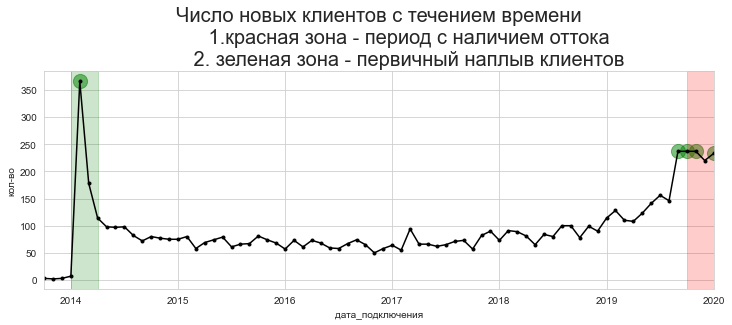

In [58]:
size_by_join_date.plot(color='black', marker='.', figsize = (12, 4))
top = size_by_join_date.sort_values(ascending = False).head(5)
for k, v in top.items():
    plt.scatter(k, v, s = 200, alpha=.5, color = 'green')
plt.axvspan(churn_first, churn_last, color = 'red', alpha=.2)
plt.axvspan(size_by_join_date.index[3], size_by_join_date.index[6], color = 'green', alpha = .2)
plt.title('Число новых клиентов с течением времени\n\
           1.красная зона - период с наличием оттока\n\
           2. зеленая зона - первичный наплыв клиентов', fontsize =20)
plt.ylabel('кол-во')
plt.show()

#### Выводы:
1. первичный наплыв клиентов: 2014-02-01
2. период с оттоком:  2019-10-01:2020-01-01
3. последний месяц с подключениями в оттоке не учитывается (новые клиенты): 2020-02-01
4. c 2019-09-01 наблюдается интесивное появление новых клиентов


#### 3.2. определение целевого признака

In [9]:
data = data[data['дата_подключения']!=join_last]
data = convert_types(data)
data['длительность_подключения'] = (data['дата_отключения'].fillna(join_last)- data['дата_подключения']) / np.timedelta64(30, 'D')

# целевой признак, признаки
target = data['дата_отключения'].isna().astype(np.int32)
features = data.drop(['дата_отключения', 'дата_подключения'], 1)

#### 3.3. распределение целевого признака (выбор схемы валидации)

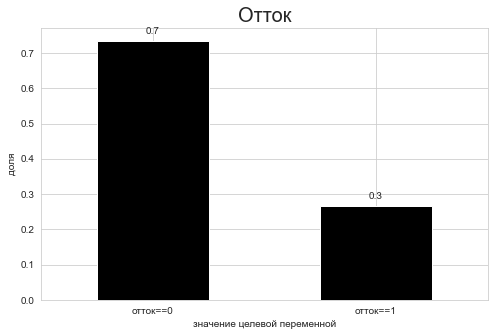

In [10]:
target_bp = target.value_counts(normalize = True).plot(kind='bar', color='black', figsize = (8, 5))
target_bp.set_xticklabels(['отток==0', 'отток==1'], rotation=0)
target_bp.set_title('Отток', fontsize = 20)
target_bp.set_ylabel('доля')
target_bp.set_xlabel('значение целевой переменной')

for p in target_bp.patches:
    target_bp.annotate(format(p.get_height(), '.1f'),\
                       (p.get_x() + p.get_width() / 2., p.get_height()),\
                       ha = 'center',\
                       va = 'center',\
                       xytext = (0, 10),\
                       textcoords = 'offset points')
plt.show()

#### Выводы:
1. доля отточных клиентов равна ~30%
2. из-за дисбаланса классов будем использовать стратифицированное разбиение на тренировочную-отложенную-тестовую части; в качестве схемы валидации также будем использовать StratifiedKFold.

#### 3.4. анализ пропущенных значений

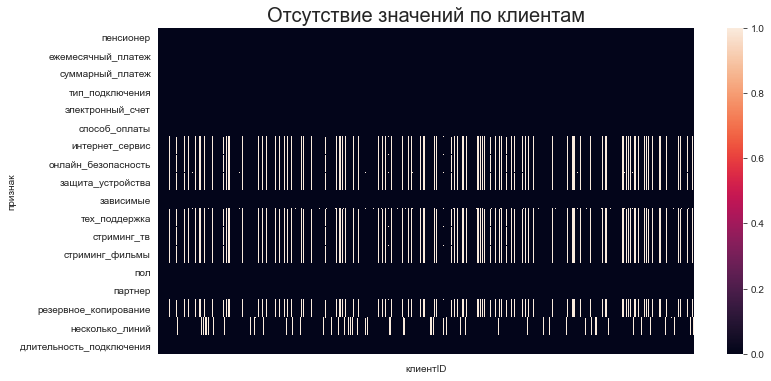

In [11]:
plt.figure(figsize = (12, 6))
hm = sns.heatmap(features.isna().T)
hm.set_xticklabels([])
hm.set_title('Отсутствие значений по клиентам', fontsize = 20)   
hm.set_ylabel('признак') ;

In [12]:
# признаки с np.nan
columns_with_na = features.columns[features.isna().any()]
ser_nan_share = features[columns_with_na].isna().mean(1)

print('\t\t\tПризнаки с np.nan')
for share in np.unique(ser_nan_share):
    _subdf= features[ser_nan_share == share]
    _colnames = features.columns[_subdf.isna().any()].tolist()
    print('доля записей = {:.0%}'.format(_subdf.shape[0]/features.shape[0]))
    print('признаки:')    
    for i, v in enumerate(_colnames):
        print('\t{}. {:<21} {} {:>12} - самое популярное'.format(i+1, v,\
                                          sorted(list(map(str, features[v].unique()))), features[v].value_counts().idxmax()))
    print('--------------------------------------------------------------------------------')
    

			Признаки с np.nan
доля записей = 69%
признаки:
--------------------------------------------------------------------------------
доля записей = 10%
признаки:
	1. несколько_линий       ['No', 'Yes', 'nan']           No - самое популярное
--------------------------------------------------------------------------------
доля записей = 22%
признаки:
	1. интернет_сервис       ['DSL', 'Fiber optic', 'nan']  Fiber optic - самое популярное
	2. онлайн_безопасность   ['No', 'Yes', 'nan']           No - самое популярное
	3. защита_устройства     ['No', 'Yes', 'nan']           No - самое популярное
	4. тех_поддержка         ['No', 'Yes', 'nan']           No - самое популярное
	5. стриминг_тв           ['No', 'Yes', 'nan']           No - самое популярное
	6. стриминг_фильмы       ['No', 'Yes', 'nan']           No - самое популярное
	7. резервное_копирование ['No', 'Yes', 'nan']           No - самое популярное
--------------------------------------------------------------------------------


#### Выводы:
1. данные отсутствуют в признаке "несолько линий" - одновременный прием звонков возможен только в рамках одной линии
2. в остальных признаках считаем, что отсутсвуие значений - это наличие самого попуярного

#### 3.5. анализ числовых признаков

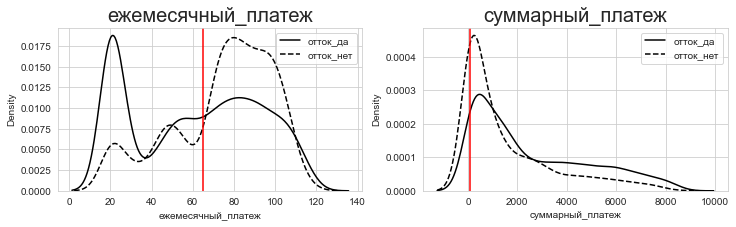

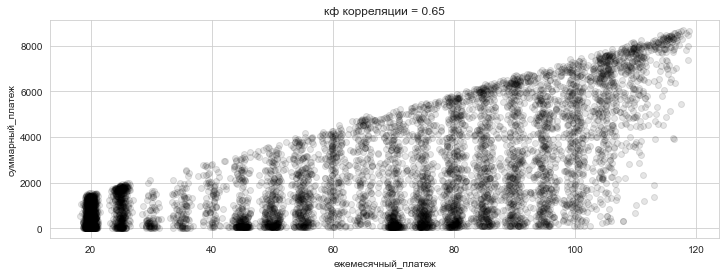

In [13]:
plt.figure(figsize = (12, 3))

plt.subplot(1, 2, 1)
sns.kdeplot(features[target==1]['ежемесячный_платеж'], color='black')
sns.kdeplot(features[target!=1]['ежемесячный_платеж'], color='black', linestyle='--')
plt.legend(['отток_да', 'отток_нет'])
plt.axvline(features['ежемесячный_платеж'].mean(), color = 'red')
plt.title('ежемесячный_платеж', fontsize = 20)

plt.subplot(1, 2, 2)
sns.kdeplot(features[target==1]['суммарный_платеж'], color='black')
sns.kdeplot(features[target!=1]['суммарный_платеж'], color='black', linestyle='--')
plt.axvline(features['ежемесячный_платеж'].mean(), color = 'red')
plt.legend(['отток_да', 'отток_нет'])
plt.title('суммарный_платеж', fontsize = 20)
plt.show()

plt.figure(figsize = (12, 4))
plt.subplot(1, 1, 1)

plt.scatter(features['ежемесячный_платеж'], features['суммарный_платеж'],color='black', alpha = .1)
plt.title('кф корреляции = {:.2f}'\
          .format(features[['ежемесячный_платеж']].corrwith(features['суммарный_платеж']).values.flatten()[0]))
plt.xlabel('ежемесячный_платеж')
plt.ylabel('суммарный_платеж')
plt.show()

#### Выводы:
1. ежемесячный и суммарный платежи у отточных и оставшихся клиентов разные

In [14]:
df_feat_target = features.copy()
df_feat_target['отток'] = target

#### 3.6. анализ категориальных признаков

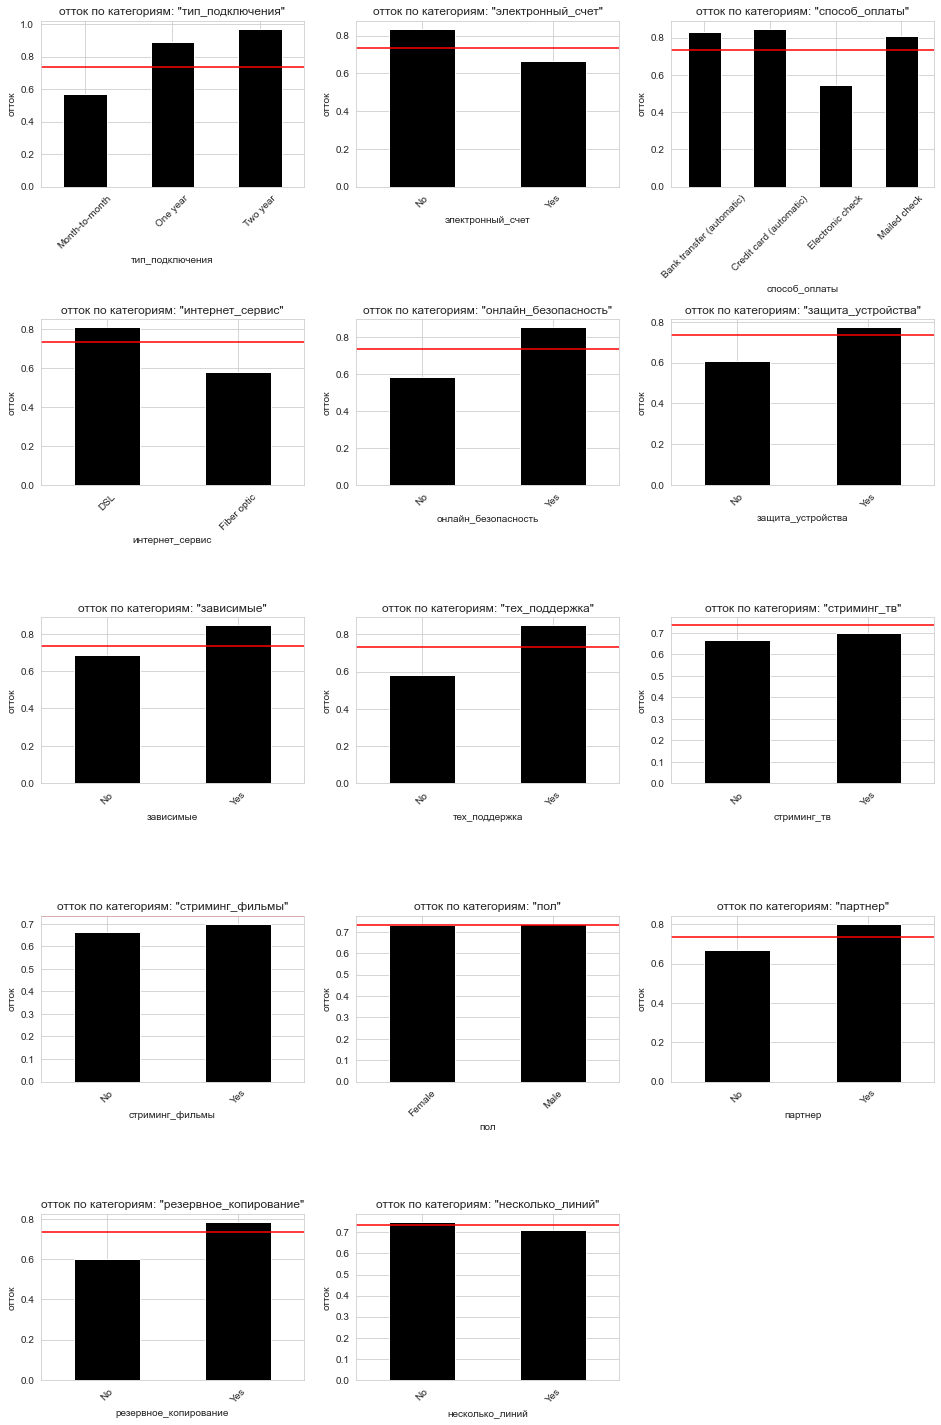

In [15]:
str_features = df_feat_target.select_dtypes(object).columns
ncols = 3
nrows = np.int32(np.ceil(len(str_features)/ncols))

fig = plt.figure(figsize = (16, 25))
for i, col in enumerate(str_features):
    plt.subplot(nrows, ncols, i+1)
    bp = df_feat_target.groupby(col)['отток'].mean().plot(kind = 'bar', color ='black')
    bp.set_xticklabels(bp.get_xticklabels(), rotation = 45)
    plt.axhline(df_feat_target['отток'].mean(), color = 'red')
    bp.set_title(f'отток по категориям: "{col}"')
    bp.set_xlabel(col)
    bp.set_ylabel('отток')
plt.subplots_adjust(hspace = .8)    

#### 3.7. проверка гипотез

In [16]:
def bootstrap_2samp_means(sample_churn, sample_notchurn, n_samples, sample_size, n_iterations, random_state, alpha):
    L_results = []
    for _ in range(n_iterations):
        np.random.seed(random_state+_)
        churn_bt_means = np.mean(np.random.choice(sample_churn, (n_samples, sample_size)), 1)
        notchurn_bt_means = np.mean(np.random.choice(sample_notchurn, (n_samples, sample_size)), 1)
        if stats.ttest_ind(churn_bt_means, notchurn_bt_means)[1] < ALPHA:
            L_results.append('средние разные, alpha = {}'.format(alpha))
        else:
            L_results.append('средние одинаковые, alpha = {}'.format(alpha))
    return pd.Series(L_results).value_counts().idxmax()

In [17]:
total_payment_sample_churn = features[target==1]['суммарный_платеж'].values
total_payment_sample_notchurn = features[target!=1]['суммарный_платеж'].values

print('суммарный_платеж : {}'.format(bootstrap_2samp_means(total_payment_sample_churn, total_payment_sample_notchurn,\
                      n_samples=1000, sample_size=10, n_iterations=100,\
                      random_state=SEED, alpha=ALPHA)))

суммарный_платеж : средние разные, alpha = 0.05


In [18]:
avg_payment_sample_churn = features[target==1]['ежемесячный_платеж'].values
avg_payment_sample_notchurn = features[target!=1]['ежемесячный_платеж'].values

print('ежемесячный_платеж : {}'.format(bootstrap_2samp_means(avg_payment_sample_churn, avg_payment_sample_notchurn,\
                      n_samples=1000, sample_size=10, n_iterations=100,\
                      random_state=SEED, alpha=ALPHA)))

ежемесячный_платеж : средние разные, alpha = 0.05


In [19]:
for i, col in enumerate(str_features):
    print(str.upper(col))
    ser = df_feat_target[col]
    uniques = ser.dropna().unique()
    k = 1
    for i in range(len(uniques)):
        for j in range(i+1, len(uniques)):
            v1, v2 = uniques[i], uniques[j]
            samp1 = df_feat_target[ser == v1]['отток']
            samp2 = df_feat_target[ser == v2]['отток']
            res = bootstrap_2samp_means(samp1, samp2,\
                      n_samples=1000, sample_size=10, n_iterations=100,\
                      random_state=SEED, alpha=ALPHA)
            print('\t{}. v1 = {}, v2 = {}: {}'.format(k, v1, v2, res))
            k+=1
    print('-----------------------------------------------------------------------------------------------------')

ТИП_ПОДКЛЮЧЕНИЯ
	1. v1 = Two year, v2 = One year: средние разные, alpha = 0.05
	2. v1 = Two year, v2 = Month-to-month: средние разные, alpha = 0.05
	3. v1 = One year, v2 = Month-to-month: средние разные, alpha = 0.05
-----------------------------------------------------------------------------------------------------
ЭЛЕКТРОННЫЙ_СЧЕТ
	1. v1 = No, v2 = Yes: средние разные, alpha = 0.05
-----------------------------------------------------------------------------------------------------
СПОСОБ_ОПЛАТЫ
	1. v1 = Credit card (automatic), v2 = Bank transfer (automatic): средние разные, alpha = 0.05
	2. v1 = Credit card (automatic), v2 = Electronic check: средние разные, alpha = 0.05
	3. v1 = Credit card (automatic), v2 = Mailed check: средние разные, alpha = 0.05
	4. v1 = Bank transfer (automatic), v2 = Electronic check: средние разные, alpha = 0.05
	5. v1 = Bank transfer (automatic), v2 = Mailed check: средние разные, alpha = 0.05
	6. v1 = Electronic check, v2 = Mailed check: средние разные,

### 4. Моделирование

#### 4.1. Выбор схемы валидации

In [20]:
SKF = StratifiedKFold(10, random_state = SEED, shuffle = True)

#### 4.1. Разбивка данных

In [22]:
X_tr, X_ho, X_te, y_tr, y_ho, y_te = train_hold_test_split(features, target,\
                                                           tr_size=.9, ho_size=.1,\
                                                           shuffle=True, random_state=SEED,\
                                                           stratify=True, use_test=True)

In [23]:
imputer =  SimpleImputer(strategy='most_frequent')
imputer.fit(X_tr)
X_tr.loc[:, :] = imputer.transform(X_tr)
X_ho.loc[:, :] = imputer.transform(X_ho)
X_te.loc[:, :] = imputer.transform(X_te)

#### 4.2. Формирование пайплайнов

In [24]:
# числа
num_columns = features.select_dtypes('number').columns.tolist()
# строки
str_columns = features.select_dtypes(exclude = 'number').columns.tolist()
# проверяем размеры таблиц
assert (len(num_columns)+len(str_columns)) == features.shape[1]

In [25]:
PPL_STR_LABEL = make_pipeline(SklearnHelperColumnSelector(str_columns),\
                              SklearnHelperLabelEncoder())
PPL_STR_TARGET = make_pipeline(SklearnHelperColumnSelector(str_columns),\
                               SklearnHelperTargetEncoder(n_iter = 5,n_folds = 20,min_samples_leaf = 2,seed = SEED))
PPL_STR_DUMMY = make_pipeline(SklearnHelperColumnSelector(str_columns),\
                              OneHotEncoder(handle_unknown='ignore'))
PPL_NUM_RAW = make_pipeline(SklearnHelperColumnSelector(num_columns))

#### сгенерируем разные пайплайны (если использовать все типы кодирования одновременно, можно упустить переобучение на тренировочную часть)

In [26]:
def create_pipelines(model, metric):
    L_pipelines = []
    L_feature_names = []
    
    L_pipelines.append(make_pipeline(make_union(PPL_STR_LABEL, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
    L_feature_names.append(PPL_STR_LABEL.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)

    L_pipelines.append(make_pipeline(make_union(PPL_STR_TARGET, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
    L_feature_names.append(PPL_STR_TARGET.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)

    L_pipelines.append(make_pipeline(make_union(PPL_STR_DUMMY, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False))) 
    L_feature_names.append(PPL_STR_DUMMY.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)
    L_pipelines.append(make_pipeline(make_union(PPL_STR_LABEL, PPL_STR_TARGET, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
    L_feature_names.append(PPL_STR_LABEL.steps[0][1].columns+\
                           PPL_STR_TARGET.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)


    L_pipelines.append(make_pipeline(make_union(PPL_STR_LABEL, PPL_STR_DUMMY, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
    L_feature_names.append(PPL_STR_LABEL.steps[0][1].columns+\
                           PPL_STR_DUMMY.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)
    
    L_pipelines.append(make_pipeline(make_union(PPL_STR_TARGET, PPL_STR_DUMMY, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
    L_feature_names.append(PPL_STR_TARGET.steps[0][1].columns+\
                           PPL_STR_DUMMY.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)

    L_pipelines.append(make_pipeline(make_union(PPL_STR_TARGET, PPL_STR_LABEL, PPL_STR_DUMMY, PPL_NUM_RAW),\
                                    MaxAbsScaler(),\
                                    SklearnHelperFeatureSelector(\
                                                             model = model,\
                                                             cv = SKF,  scoring = metric,
                                                             show_progress = False)))
                          
    L_feature_names.append(PPL_STR_TARGET.steps[0][1].columns+\
                           PPL_STR_LABEL.steps[0][1].columns+\
                           PPL_STR_DUMMY.steps[0][1].columns+\
                           PPL_NUM_RAW.steps[0][1].columns)
    
    return list(zip(L_feature_names, L_pipelines))

#### 4.3. Выполнение пайплайнов
* прогоним все пайплайны для линейныой и деревянной моделей
* проанализируем метрики и распределения ошибок
* выберем оптимизируемую метрику
* проведем более подробный анализ

In [27]:
TR_FOLDER = r'D:\yandex_final_tr' 
HO_FOLDER = r'D:\yandex_final_ho' 
TE_FOLDER = r'D:\yandex_final_te' 
PIPELINES_FOLDER = r'D:\yandex_final_models' 

if not os.path.exists(TR_FOLDER):
    os.makedirs(TR_FOLDER)
else:
    shutil.rmtree(TR_FOLDER)
    os.makedirs(TR_FOLDER)
    
if not os.path.exists(HO_FOLDER):
    os.makedirs(HO_FOLDER)
else:
    shutil.rmtree(HO_FOLDER)
    os.makedirs(HO_FOLDER)
    
if not os.path.exists(TE_FOLDER):
    os.makedirs(TE_FOLDER)
else:
    shutil.rmtree(TE_FOLDER)
    os.makedirs(TE_FOLDER)
    
if not os.path.exists(PIPELINES_FOLDER):
    os.makedirs(PIPELINES_FOLDER)
else:
    shutil.rmtree(PIPELINES_FOLDER)
    os.makedirs(PIPELINES_FOLDER)
    
METRICS = ['accuracy', 'f1', 'precision', 'recall']
D_MODELS = {'lgb':LGBMClassifier(n_jobs=-1, random_state = SEED),            
            'logit':LogisticRegression(random_state = SEED),
            'knn':KNeighborsClassifier(),
            'svm':LinearSVC()}

In [59]:
%%time

L_baselines =[]
# перебираем метрики качества
for metric in tqdm_notebook(METRICS):
    
    for model_name, model in tqdm_notebook(D_MODELS.items()):
        
        # считаем бейзлайн
        baseline = cross_val_score(DummyClassifier('most_frequent'), X_tr, y_tr, cv = SKF, scoring = metric).mean()
        
        # коллеционируем бейзлайн
        L_baselines.append((metric, model, baseline))
        
        # генерируем пайплайны
        L_ppl = create_pipelines(model = model, metric= metric)
        
        # выполянем пайпалйны
        L_feat_selected = []
        for k, names_ppl in tqdm_notebook(enumerate(L_ppl), total = len(L_ppl)):
            feat_names, ppl = names_ppl
            ppl.fit(X_tr, y_tr)
            try:
                selected_features = np.array(feat_names)[ppl.steps[-1][1].best_features_]            
            except:
                selected_features = 'ohe'
                
            
            x_tr, x_ho, x_te = ppl.transform(X_tr), ppl.transform(X_ho), ppl.transform(X_te)        
        
            filename = '{}_{}_{}.pickle'.format(metric, model_name, k)
            # экспортиртируем признаки
            with open(os.path.join(TR_FOLDER, filename), 'wb') as f:
                pickle.dump(x_tr, f)
            with open(os.path.join(HO_FOLDER, filename), 'wb') as f:
                pickle.dump(x_ho, f)
            with open(os.path.join(TE_FOLDER, filename), 'wb') as f:
                pickle.dump(x_te, f)
                
            tuner = SklearnHelperClassifierHPTuner(\
                                model = model,\
                                cv = SKF,\
                                scoring = metric)
            tuner.fit(x_tr, y_tr)
            # экспортируем оптимизированную модель
            with open(os.path.join(PIPELINES_FOLDER, filename), 'wb') as f:
                pickle.dump((selected_features, tuner), f) 
                
with open('L_baselines.pickle', 'wb') as f:
    pickle.dump(L_baselines, f)

#### 4.4. Анализ результатов

In [60]:
with open('L_baselines.pickle', 'rb') as f:
    L_baselines = pickle.load(f) 
L_cvAB, L_ho_predictions, L_te_predictions, L_selected_features, L_X_tr, L_tuners = [], [], [], [], [], []
for filename in tqdm_notebook(os.listdir(TR_FOLDER)):
    
    # пути к признакам, моделям
    path_to_file_tr = os.path.join(TR_FOLDER, filename)
    path_to_file_ho = os.path.join(HO_FOLDER, filename)
    path_to_file_te = os.path.join(TE_FOLDER, filename)
    path_to_tuner = os.path.join(PIPELINES_FOLDER, filename)
    
    # загружаем
    with open(path_to_file_tr, 'rb') as f:
        x_tr = pickle.load(f)
    with open(path_to_file_ho, 'rb') as f:
        x_ho = pickle.load(f)
    with open(path_to_file_te, 'rb') as f:
        x_te = pickle.load(f)
    with open(path_to_tuner, 'rb') as f:
        selected_features, tuner = pickle.load(f)
        
    if 'accuracy' in path_to_file_tr:
        mean_cv_score = tuner.best_score_
        y_pred_ho = tuner.best_estimator_.predict(x_ho)
        y_pred_te = tuner.best_estimator_.predict(x_te)
        ho_score = precision_score(y_ho, y_pred_ho)
        
    elif 'f1' in path_to_file_tr:
        mean_cv_score = tuner.best_score_
        y_pred_ho = tuner.best_estimator_.predict(x_ho)
        y_pred_te = tuner.best_estimator_.predict(x_te)
        ho_score = precision_score(y_ho, y_pred_ho)
        
    elif 'precision' in path_to_file_tr:
        mean_cv_score = tuner.best_score_
        y_pred_ho = tuner.best_estimator_.predict(x_ho)
        y_pred_te = tuner.best_estimator_.predict(x_te)
        ho_score = precision_score(y_ho, y_pred_ho)
        
    elif 'recall' in path_to_file_tr:
        mean_cv_score = tuner.best_score_
        y_pred_ho = tuner.best_estimator_.predict(x_ho)
        y_pred_te = tuner.best_estimator_.predict(x_te)
        ho_score = recall_score(y_ho, y_pred_ho) 
        
    l = path_to_file_tr.split('\\')[-1][:-7].split('_')
    metric = '_'.join(l[:-2])
    model = l[-2]
    ppl_idx = l[-1]  
    
    if len(np.unique(y_pred_ho.flatten()))!=1:
        L_cvAB.append((metric, model, ppl_idx, mean_cv_score, ho_score))
        L_ho_predictions.append(y_pred_ho)
        L_te_predictions.append(y_pred_te)
        L_selected_features.append(selected_features)
        L_X_tr.append(x_tr)
        L_tuners.append(tuner)

In [236]:
cvAB = pd.DataFrame(L_cvAB, columns = ['metric', 'model', 'ppl_idx', 'cv','ho'])    

In [237]:
cvAB[cvAB['ho'] >= cvAB['cv']].sort_values('cv', ascending = False).drop_duplicates(subset = ['metric'], keep='first')                

,metric,model,ppl_idx,cv,ho
13,recall,svm,0,0.941159,0.950538
8,precision,knn,0,0.914278,0.925743
1,accuracy,lgb,0,0.865843,0.892713


In [238]:
report_df = pd.DataFrame(np.column_stack([L_ho_predictions[13].reshape(-1,1),\
                              L_ho_predictions[8].reshape(-1,1),\
                              L_ho_predictions[1].reshape(-1,1)]), columns = ['svm_recall', 'knn_precision', 'lgb_accuracy'])
report_df['y_trues'] = y_ho.values

In [239]:
L_errors = []
for col in report_df.columns[:-1]:
    preds= report_df[col]
    
    churned = report_df['y_trues'] == 1
    notchurned = report_df['y_trues'] == 0
    pred_churned = preds==1
    pred_notchurned = preds==0
    fn = (pred_notchurned&churned).sum()
    fp = (pred_churned&notchurned).sum()
    
    L_errors.append((fp, fn))

In [240]:
df_errors = pd.DataFrame(L_errors, columns = ['fp', 'fn'],index = report_df.columns[:-1])

In [241]:
df_errors

,fp,fn
svm_recall,132,23
knn_precision,30,91
lgb_accuracy,53,24


#### Выводы:
1. svm+recall:ложных срабатываний - 132, ложных пропусков - 23
2. knn+precision:ложных срабатываний - 30, ложных пропусков - 91
3. lgb+accuracy:ложных срабатываний - 53, ложных пропусков - 24

In [242]:
report_df['суммарный_платеж'] = X_ho['суммарный_платеж'].values
report_df['длительность_подключения'] = X_ho['длительность_подключения'].values

In [243]:
report_df2 = pd.concat([report_df[(report_df['svm_recall']==0) & (report_df['y_trues']==1)].iloc[:, -2:].mean(),\
           report_df[(report_df['knn_precision']==0) & (report_df['y_trues']==1)].iloc[:, -2:].mean(),\
           report_df[(report_df['lgb_accuracy']==0) & (report_df['y_trues']==1)].iloc[:, -2:].mean()], 1)
report_df2.columns=df_errors.index
report_df2 = report_df2.add_suffix('_упущено')

In [244]:
report_df2

,svm_recall_упущено,knn_precision_упущено,lgb_accuracy_упущено
суммарный_платеж,676.108699,1327.968681,1288.664583
длительность_подключения,8.194203,19.144689,13.713889


In [245]:
report_df2['svm_recall_упущено'] / report_df2['lgb_accuracy_упущено']

суммарный_платеж            0.524658
длительность_подключения    0.597511
dtype: float64

#### Выводы:
1) необходимо сравнить упущенную прибыль и затраты на выдачу лишних промокодов с учетом длительности жизненного цикла клиента         
2) svm_recall упущено суммарный_платеж, меньший, чем lgb_accuracy, в 0.52         
3) svm_recall упущено длительность_подключения, меньший, меньше чем lgb_accuracy, в 0.6

#### Я бы боролся за удержание клиентов. Это положительно влияет на имидж компании, а так как Яндекс имеет множество монетизирующихся сервисов, удержание клиентов  является более предпочтительным

In [246]:
print('recall на тестовой выборке = {:.2f}'.format(recall_score(y_te, L_te_predictions[13])))

recall на тестовой выборке = 0.95


In [247]:
_df = pd.DataFrame(L_X_tr[13].toarray())

In [248]:
_df.head()

,0,1,2,3,4,5,6
0,0.736650,0.0,0.0,0.0,0.0,0.0,0.0
1,0.708809,1.0,1.0,1.0,0.0,0.0,1.0
2,0.292560,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014149,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,1.0,1.0,1.0,1.0,1.0,1.0


In [229]:
L = X_tr.columns[X_tr.nunique() == _df[0].nunique()].tolist()
for col1 in _df.columns[1:]:
    v = _df[col1].values    
    for col2 in X_tr.select_dtypes(object):
        ohe = X_tr[col2].factorize()[0]
        if (v == ohe).all() or (v != ohe).all():
            L.append(col2)

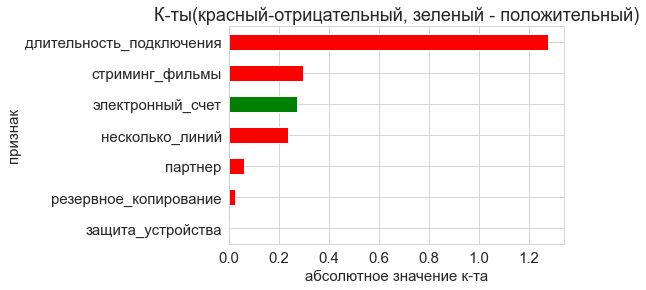

In [279]:
ser_coef_imp = pd.Series(dict(zip(L, L_tuners[13].coef_imp_)))
ser_coef_imp.abs().sort_values()
colors = (ser_coef_imp>0).map({True:'green', False:'red'}).values.tolist()
ser_coef_imp.abs().sort_values().plot(kind ='barh', color = colors)
plt.title('К-ты(красный-отрицательный, зеленый - положительный)')
plt.xlabel('абсолютное значение к-та')
plt.ylabel('признак')
plt.show()

## Формулировка выводов
1. был выбран актуальный временной отрезок
2. пропущенные значения обрабатывались заменой на самую популярную категорию
3. модели валидировались в скользящемокне для учета временного тренда
4. категории кодировались с помощью дамми-кодирования, лейбл-кодироавния, таргет-кодирования(в разных комбинациях, для разных типов моделей)
5. использовались модели: LGBMClassifier(n_jobs=-1, random_state = SEED),RandomForestClassifier(n_jobs=-1, random_state = SEED),ExtraTreesClassifier(n_jobs=-1, random_state = SEED),DecisionTreeClassifier(),ExtraTreeClassifier(), KNeighborsClassifier(),LogisticRegression(),LinearSVC()
6. опитимизировались метрики: 'accuracy', 'f1', 'precision', 'recall'
7. svm+recall:ложных срабатываний - 132, ложных пропусков - 23                
   knn+precision:ложных срабатываний - 30, ложных пропусков - 91                 
   lgb+accuracy:ложных срабатываний - 53, ложных пропусков - 24                
8. Я бы боролся за удержание клиентов. Это положительно влияет на имидж компании, а так как Яндекс имеет множество      монетизирующихся сервисов, удержание клиентов является более предпочтительным
9. наиболее важными являются признаки:          
   9.1. длительность_подключения(обратная зависимость от вероятности оттока)         
   9.2. стриминг_фильмы(обратная зависимость от вероятности оттока)
   9.3. электронный_счет(прямая зависимость от вероятности оттока)        
10. при большем размере выборки стоит построить ансамбль моделей (может быть даже многоуровневый)

In [326]:
class SklearnHelperStackingRegressor(BaseEstimator, TransformerMixin):
    def __init__(self, L_base_models, nfolds, seed, path_to_folder):
        self.L_base_models = L_base_models
        self.nfolds = nfolds
        self.seed = seed
        self.path_to_folder=path_to_folder
        
        if os.path.isdir(self.path_to_folder):
            shutil.rmtree(self.path_to_folder)
            os.makedirs(self.path_to_folder)
        else:
            os.makedirs(self.path_to_folder) 
            
    def fit(self, L_X, y=None):
        L_Z = []
        self.nrows = L_X[0].shape[0] 
        self.y_mean = y.mean()
        # классический стекинг
        for i, (model, X) in tqdm_notebook(enumerate(zip(self.L_base_models, L_X)),\
                                              total = len(self.L_base_models)):
            current_seed=i+self.seed
            kf = KFold(self.nfolds, random_state= current_seed, shuffle = True)
            
            
            
            
            # пустые таблицы
            Z_tr = np.zeros((y.shape[0], 1))            

            # запускаем фолдинг
            for j, (tr_idx, val_idx) in tqdm_notebook(enumerate(kf.split(X, y)),\
                                                      total = self.nfolds):
                model.fit(X[tr_idx], y[tr_idx])
                
                filename = os.path.join(self.path_to_folder, f'model_{i+1}_{j+1}.pickle')
                with open(filename, 'wb') as f:
                    pickle.dump((model, i, j), f)
                    
                Z_tr[val_idx, 0] = model.predict(X[val_idx])                

            L_Z.append(Z_tr)
            
        self.Z = np.column_stack(L_Z)        
        return self
    
    def predict(self, L_X):
        if self.nrows == L_X[0].shape[0]:
            return self.Z     
        else:  
            folder_with_models = os.listdir(self.path_to_folder)
            L = []
            for file in tqdm_notebook(folder_with_models):    
                with open(os.path.join(self.path_to_folder, file), 'rb') as f:
                    model, i, j =pickle.load(f)
                L.append(model.predict(L_X[i])) 
            XX_meta = np.column_stack(L)
            X_meta = np.column_stack([arr.mean(1) for arr in np.array_split(XX_meta, len(self.L_base_models), axis = 1)])
            
            return X_meta